<a href="https://colab.research.google.com/github/Nada-Elghaweet/Ai-safety-system/blob/main/RandomForestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload the dataset zip file and extract it
from google.colab import files
import zipfile
import os

print("Upload your dataset zip file (e.g., VIOLENCE VS NON_VIOLENCE.zip)")
uploaded = files.upload()

zip_name = 'VIOLENCE VS NON_VIOLENCE.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted. Contents:")
print(os.listdir(extract_path))

Upload your dataset zip file (e.g., VIOLENCE VS NON_VIOLENCE.zip)


Saving VIOLENCE VS NON_VIOLENCE.zip to VIOLENCE VS NON_VIOLENCE.zip
Dataset extracted. Contents:
['VIOLENCE VS NON_VIOLENCE']


In [2]:
import glob

# Define dataset directories
DATA_DIR = 'dataset/VIOLENCE VS NON_VIOLENCE'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes found:", CLASSES)

# Function to get image paths and numeric labels
def get_image_paths_labels(split):
    image_paths, labels = [], []
    for label_idx, cls in enumerate(CLASSES):
        folder = os.path.join(DATA_DIR, split, cls)
        for img_path in glob.glob(os.path.join(folder, '*')):
            image_paths.append(img_path)
            labels.append(label_idx)
    return image_paths, labels

# Load paths and labels for train, validation, and test sets
X_train_paths, y_train = get_image_paths_labels('train')
X_val_paths, y_val = get_image_paths_labels('val')
X_test_paths, y_test = get_image_paths_labels('test')

print(f"Number of images - Train: {len(X_train_paths)}, Val: {len(X_val_paths)}, Test: {len(X_test_paths)}")

Classes found: ['non_violence', 'violence']
Number of images - Train: 700, Val: 156, Test: 117


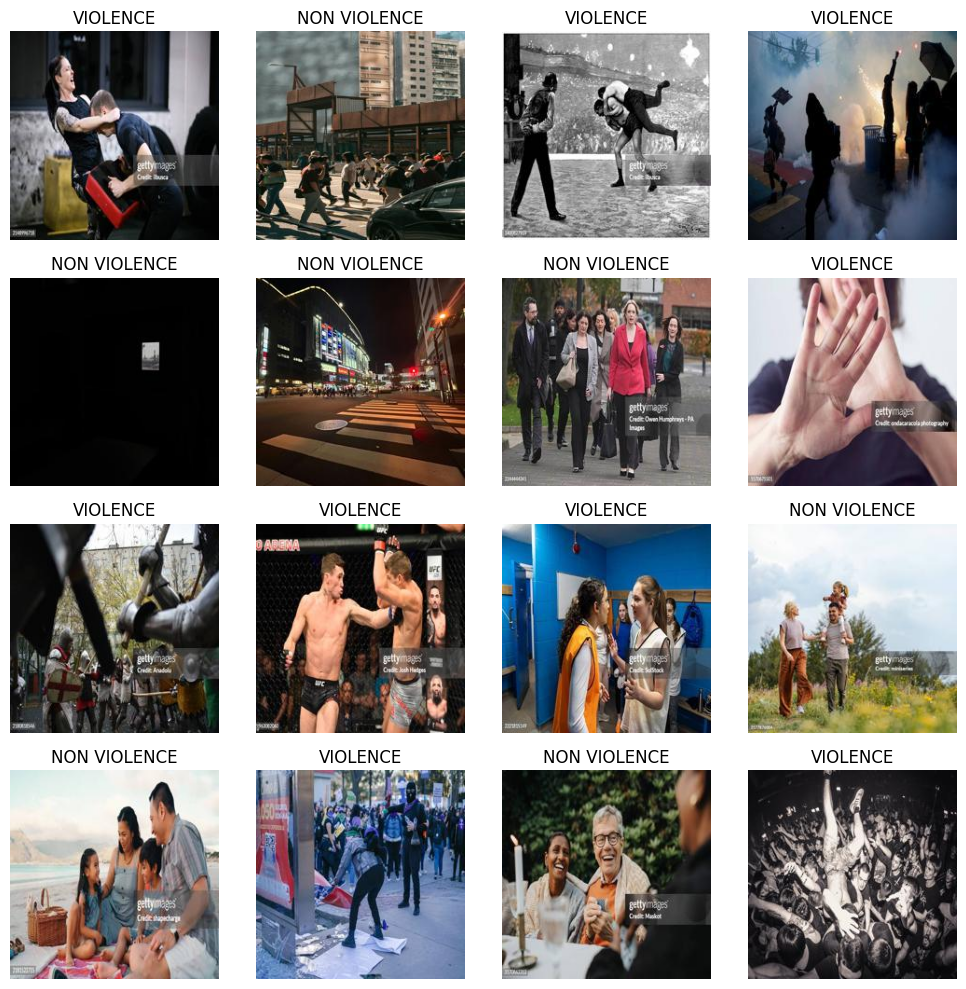

In [3]:
import matplotlib.pyplot as plt
import cv2
import random

plt.figure(figsize=(10, 10))
sample_indices = random.sample(range(len(X_train_paths)), 16)

for i, idx in enumerate(sample_indices):
    img_path = X_train_paths[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Correct colors
    label = y_train[idx]

    ax = plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('VIOLENCE' if label == 1 else 'NON VIOLENCE')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from skimage.feature import hog

def extract_features_with_labels(img_paths, labels, resize_dim=128):
    """Extract HOG + color histogram features with horizontal flip augmentation."""
    features, new_labels = [], []

    for path, label in zip(img_paths, labels):
        img = cv2.imread(path)
        img = cv2.resize(img, (resize_dim, resize_dim))

        # HOG features
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        # Color histogram
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))
        new_labels.append(label)

        # Horizontal flip augmentation
        img_flip = cv2.flip(img, 1)
        gray_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2GRAY)
        hog_flip = hog(gray_flip, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)
        hist_flip = cv2.calcHist([img_flip], [0, 1, 2], None,
                                 [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist_flip = cv2.normalize(hist_flip, hist_flip).flatten()

        features.append(np.hstack([hog_flip, hist_flip]))
        new_labels.append(label)

    return np.array(features), np.array(new_labels)

def extract_features(img_paths, resize_dim=128):
    """Extract HOG + color histogram features without labels (for val/test)."""
    features = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (resize_dim, resize_dim))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       feature_vector=True)

        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))

    return np.array(features)

In [5]:
X_train_features, y_train_aug = extract_features_with_labels(X_train_paths, y_train, resize_dim=128)
X_val_features = extract_features(X_val_paths, resize_dim=128)
X_test_features = extract_features(X_test_paths, resize_dim=128)

print("Feature Shapes:")
print("Train:", X_train_features.shape)
print("Val:", X_val_features.shape)
print("Test:", X_test_features.shape)


Feature Shapes:
Train: (1400, 8612)
Val: (156, 8612)
Test: (117, 8612)


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Increase n_estimators, reduce min_samples_leaf slightly
rf = RandomForestClassifier(
    n_estimators=700,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_features, y_train_aug)

RandomForestClassifier(min_samples_split=3, n_estimators=700, n_jobs=-1,
                       random_state=42)

In [7]:
from sklearn.metrics import accuracy_score, classification_report

# Validation
val_pred = rf.predict(X_val_features)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

# Test
test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))

Validation Accuracy: 0.6923076923076923
              precision    recall  f1-score   support

non_violence       0.63      0.92      0.75        78
    violence       0.86      0.46      0.60        78

    accuracy                           0.69       156
   macro avg       0.74      0.69      0.68       156
weighted avg       0.74      0.69      0.67       156

Test Accuracy: 0.5384615384615384
              precision    recall  f1-score   support

non_violence       0.26      0.95      0.41        20
    violence       0.98      0.45      0.62        97

    accuracy                           0.54       117
   macro avg       0.62      0.70      0.52       117
weighted avg       0.86      0.54      0.58       117



In [8]:
# Convert predicted probabilities into human-readable labels
pred_probs = rf.predict_proba(X_test_features)[:, 1]

pred_labels = ["VIOLENCE" if prob > 0.5 else "NON VIOLENCE" for prob in pred_probs]

import pandas as pd

# Save predictions to CSV
results = pd.DataFrame({
    'filename': X_test_paths,
    'prediction': pred_labels
})

csv_filename = "random_forest_test_predictions.csv"
results.to_csv(csv_filename, index=False)
print(f"Predictions saved to {csv_filename}!")

# Preview first 5 predictions
for i in range(5):
    print(f"{X_test_paths[i]} --> {pred_labels[i]}")

Predictions saved to random_forest_test_predictions.csv!
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (440).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (444).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (407).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (299).jpg --> NON VIOLENCE
dataset/VIOLENCE VS NON_VIOLENCE/test/non_violence/NON_VIOLENCE (220).jpg --> NON VIOLENCE


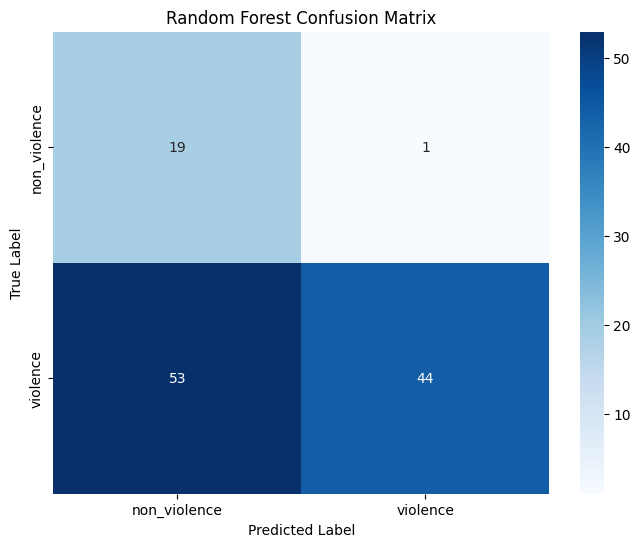

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt

# Evaluate accuracy and generalization gap for different numbers of trees
n_estimators_range = [50, 100, 200, 300, 400, 500, 600, 700]

train_acc, val_acc = [], []
train_loss, val_loss = [], []

rf_curve = RandomForestClassifier(
    n_estimators=0,  # start with zero, will warm-start
    warm_start=True,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

for n in n_estimators_range:
    rf_curve.n_estimators = n
    rf_curve.fit(X_train_features, y_train_aug)

    train_pred = rf_curve.predict(X_train_features)
    val_pred = rf_curve.predict(X_val_features)

    train_proba = rf_curve.predict_proba(X_train_features)
    val_proba = rf_curve.predict_proba(X_val_features)

    train_acc.append(accuracy_score(y_train_aug, train_pred))
    val_acc.append(accuracy_score(y_val, val_pred))

    train_loss.append(log_loss(y_train_aug, train_proba))
    val_loss.append(log_loss(y_val, val_proba))

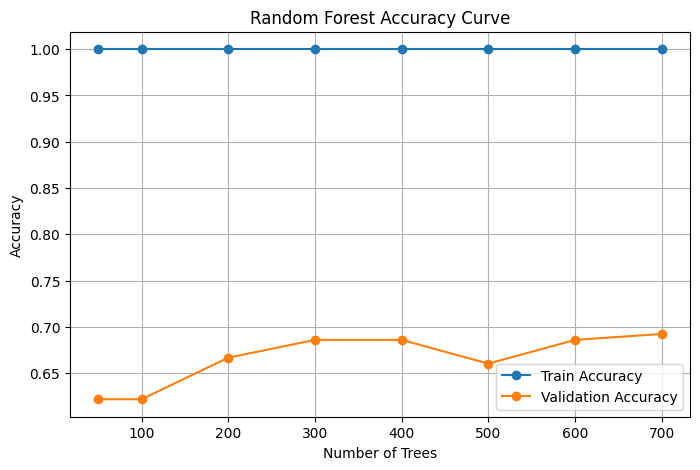

In [11]:
# Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

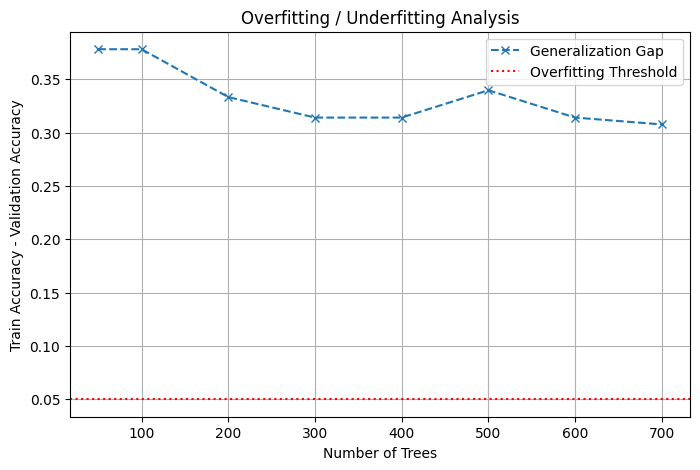

In [12]:
# Overfitting / Underfitting Analysis
gap = np.array(train_acc) - np.array(val_acc)
plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.axhline(0.05, linestyle=':', color='red', label='Overfitting Threshold')
plt.xlabel('Number of Trees')
plt.ylabel('Train Accuracy - Validation Accuracy')
plt.title('Overfitting / Underfitting Analysis')
plt.legend()
plt.grid(True)
plt.show()

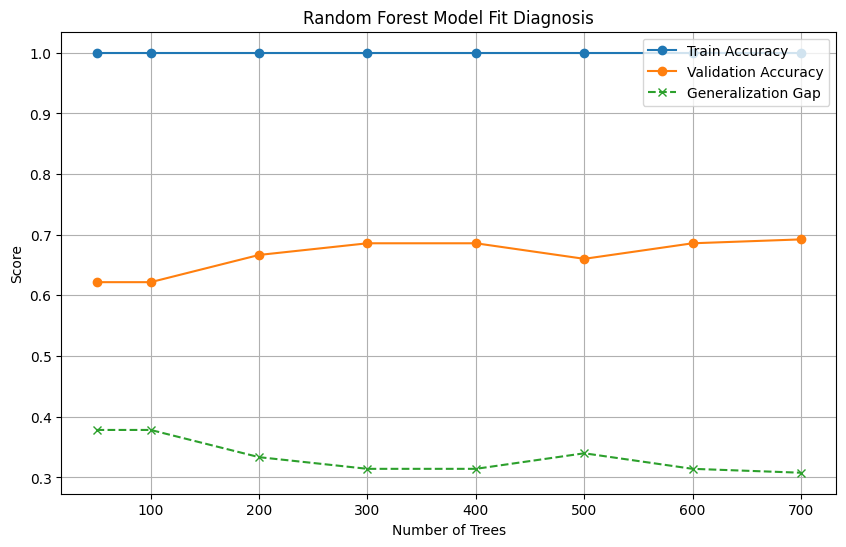

In [13]:
# Model Fit Diagnosis
plt.figure(figsize=(10,6))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='Validation Accuracy')
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Random Forest Model Fit Diagnosis')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import joblib
from google.colab import files

# Save the trained Random Forest model to disk
model_filename = "random_forest_model.pkl"
joblib.dump(rf, model_filename)
print(f"Random Forest model saved as '{model_filename}'")

# Optionally download the model to local machine
files.download(model_filename)

Random Forest model saved as 'random_forest_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>